<a href="https://colab.research.google.com/github/MoonJaeHoon/dacon_restaurant_num_people/blob/master/%5B72_7582%5DPycaret_Modeling_79_828%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 한글 패치 (matplotlib)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
# Step 1. Matplotlib 업그레이드
!pip install matplotlib -U

# Step 2. 한글 설치 및 사용 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# Step 3. 런타임 재시작

In [3]:
# Step 4. 한글 글꼴 설정
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 3. 기타 설정 (임포트 등)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
from datetime import timedelta, timezone, datetime
from copy import deepcopy
from collections import defaultdict
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
import platform
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

seed=47
def set_seed(seed: int = 42, contain_cuda: bool = False):
    random.seed(seed)
    np.random.seed(seed)

    # if contain_cuda:
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    print(f"Seed set as {seed}")
set_seed(seed)

Seed set as 47


# 4. 데이터 불러오기

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [6]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [7]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


# 5. 데이터 정제 (Dtype: object)

1. 조식, 중식, 석식메뉴는 버리기 (drop)
2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)

## 1. 조식, 중식, 석식메뉴는 버리기 (drop)

In [10]:
drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [11]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,925.0,330.0


In [12]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,2021-01-27,수,2983,88,182,5,358.0
1,2021-01-28,목,2983,104,212,409,348.0
2,2021-01-29,금,2983,270,249,0,294.0
3,2021-02-01,월,2924,108,154,538,322.0
4,2021-02-02,화,2924,62,186,455,314.0


## 2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)

In [13]:
train['월'] = pd.DatetimeIndex(train['일자']).month
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day
test['일'] = pd.DatetimeIndex(test['일자']).day

In [14]:
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

In [15]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,월,일
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2,1
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2,2
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2,3
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2,4
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2,5


In [16]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,월,일
0,2021-01-27,3,2983,88,182,5,358.0,1,27
1,2021-01-28,4,2983,104,212,409,348.0,1,28
2,2021-01-29,5,2983,270,249,0,294.0,1,29
3,2021-02-01,1,2924,108,154,538,322.0,2,1
4,2021-02-02,2,2924,62,186,455,314.0,2,2


# 6. 데이터 정제 (아이디어)

* 휴가자, 재택근무자는 중식/석식에 참여하지 않을 것이므로 본사정원수에서 차감한다.
* 즉, **본사정원수 - 휴가자 - 재택근무자**

* 식사참여율 = 식사계 / 식사가능자수

In [17]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [18]:
train['중식참여율'] = train['중식계'] / train['식사가능자수']
train['석식참여율'] = train['석식계'] / train['식사가능자수']

정제한 데이터를 정리하면,

In [19]:
features = ['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']
labels = ['중식계',	'석식계', '중식참여율', '석식참여율']

train = train[features+labels]
test = test[features]

In [20]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058


In [21]:
test.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수
0,1,27,3,2537.0,182,5
1,1,28,4,2531.0,212,409
2,1,29,5,2419.0,249,0
3,2,1,1,2494.0,154,538
4,2,2,2,2548.0,186,455


# 7. EDA, 시각화, 상관관계분석

1. 히트맵
2. 라인그래프

## 1. 히트맵

In [22]:
train.corr()[['중식계', '석식계']]

,중식계,석식계
월,-0.154664,-0.127142
일,-0.097392,-0.185565
요일,-0.731563,-0.312112
식사가능자수,0.151029,0.118615
본사출장자수,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.535611,0.571168
중식계,1.000000,0.508287
석식계,0.508287,1.000000
중식참여율,0.957156,0.475360
석식참여율,0.479768,0.973722


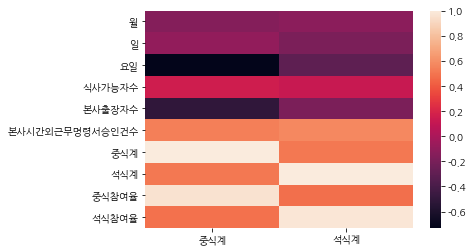

In [23]:
sns.heatmap(train.corr()[['중식계', '석식계']]);

* 중식
  1. 요일
  2. 본사시간외근무명령서승인건수
  3. 본사출장자수

* 석식
  1. 본사시간외근무명령서승인건수
  2. 요일
  3. 본사출장자수

In [24]:
train.corr()[['중식참여율', '석식참여율']]

,중식참여율,석식참여율
월,-0.166198,-0.139499
일,-0.100648,-0.186355
요일,-0.697276,-0.284943
식사가능자수,-0.133553,-0.097914
본사출장자수,-0.618408,-0.267198
본사시간외근무명령서승인건수,0.473097,0.518348
중식계,0.957156,0.479768
석식계,0.475360,0.973722
중식참여율,1.000000,0.511255
석식참여율,0.511255,1.000000


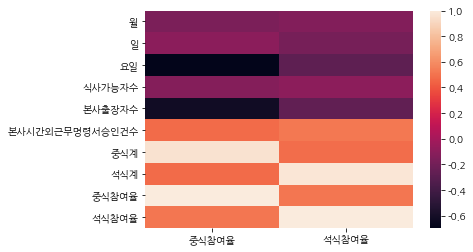

In [25]:
sns.heatmap(train.corr()[['중식참여율', '석식참여율']]);

In [26]:
train.corr()['중식참여율'].sort_values()

요일               -0.697276
본사출장자수           -0.618408
월                -0.166198
식사가능자수           -0.133553
일                -0.100648
본사시간외근무명령서승인건수    0.473097
석식계               0.475360
석식참여율             0.511255
중식계               0.957156
중식참여율             1.000000
Name: 중식참여율, dtype: float64

In [27]:
train.corr()['석식참여율'].sort_values()

요일               -0.284943
본사출장자수           -0.267198
일                -0.186355
월                -0.139499
식사가능자수           -0.097914
중식계               0.479768
중식참여율             0.511255
본사시간외근무명령서승인건수    0.518348
석식계               0.973722
석식참여율             1.000000
Name: 석식참여율, dtype: float64

## 2. 라인그래프

1. 요일
2. 월 (예정)
3. 일 (예정)

### 1. 요일

<AxesSubplot:xlabel='요일', ylabel='석식참여율'>

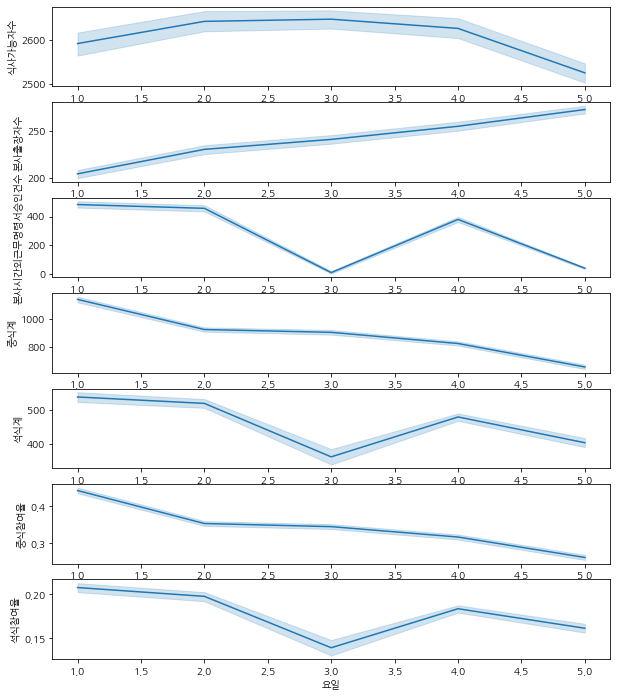

In [28]:
fig, ax = plt.subplots(7)
fig.set_size_inches(10,12)

sns.lineplot(data=train, x='요일', y='식사가능자수', ax=ax[0])
sns.lineplot(data=train, x='요일', y='본사출장자수', ax=ax[1])
sns.lineplot(data=train, x='요일', y='본사시간외근무명령서승인건수', ax=ax[2])
sns.lineplot(data=train, x='요일', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='요일', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='요일', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='요일', y='석식참여율', ax=ax[6])

요일별 데이터에서
* 중식계는 본사출장자수와 반비례 관계,
* 석식계는 본사시간외근무명령서승인건수와 정비례 관계,


로 밀접해 보임.

### 2. 월

<AxesSubplot:xlabel='월', ylabel='석식참여율'>

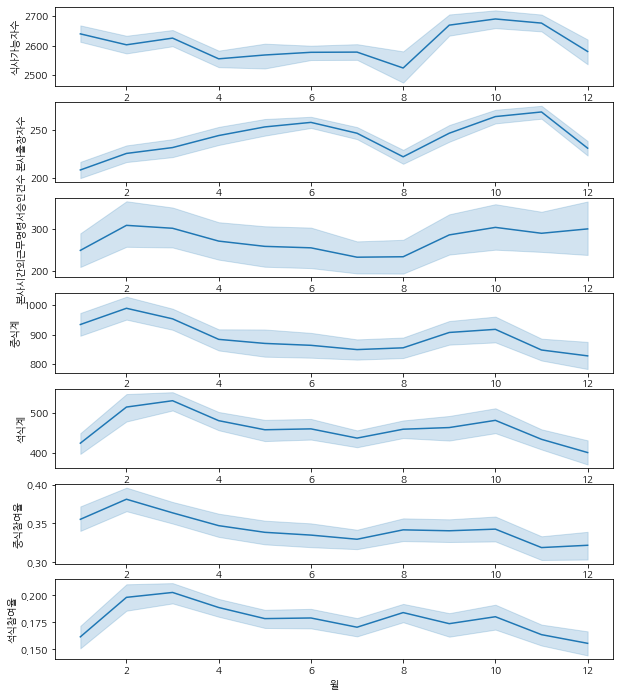

In [29]:
fig, ax = plt.subplots(7)
fig.set_size_inches(10,12)

sns.lineplot(data=train, x='월', y='식사가능자수', ax=ax[0])
sns.lineplot(data=train, x='월', y='본사출장자수', ax=ax[1])
sns.lineplot(data=train, x='월', y='본사시간외근무명령서승인건수', ax=ax[2])
sns.lineplot(data=train, x='월', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='월', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='월', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='월', y='석식참여율', ax=ax[6])

<AxesSubplot:xlabel='일', ylabel='석식참여율'>

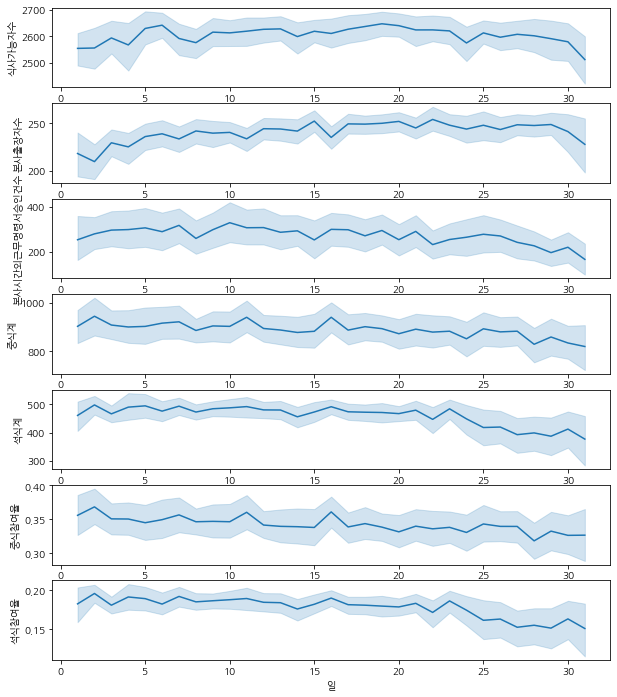

In [30]:
fig, ax = plt.subplots(7)
fig.set_size_inches(10,12)

sns.lineplot(data=train, x='일', y='식사가능자수', ax=ax[0])
sns.lineplot(data=train, x='일', y='본사출장자수', ax=ax[1])
sns.lineplot(data=train, x='일', y='본사시간외근무명령서승인건수', ax=ax[2])
sns.lineplot(data=train, x='일', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='일', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='일', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='일', y='석식참여율', ax=ax[6])

In [31]:
# 요일을 석식 rank에 맞춰 mapping한 요일(석식) 칼럼 만들기.

weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [32]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율,요일(석식)
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753,1
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522,2
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147,5
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252,3
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058,4


## 9. Pycaret Modeling


In [33]:
!pip uninstall pycaret -y

!pip install pycaret[full] ngboost shap

     |████████████████████████████████| 266kB 8.0MB/s 
     |████████████████████████████████| 358kB 50.7MB/s 
     |████████████████████████████████| 276kB 49.7MB/s 
     |████████████████████████████████| 2.0MB 39.7MB/s 
     |████████████████████████████████| 1.7MB 46.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.2MB 219kB/s 
     |████████████████████████████████| 6.8MB 21.1MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 256kB 63.5MB/s 
     |████████████████████████████████| 112kB 39.8MB/s 
     |████████████████████████████████| 1.4MB 38.1MB/s 
     |████████████████████████████████| 174kB 69.7MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 3.6MB 32.6MB/s 
     |████████████████████████████████| 348kB 47.4

In [35]:
submission = pd.read_csv('./data/sample_submission.csv')
print(submission.shape)
submission.head()

(50, 3)


,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [36]:
train.columns


Index(['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수', '중식계', '석식계',
       '중식참여율', '석식참여율', '요일(석식)'],
      dtype='object')

In [37]:
print(train.shape)

(1205, 11)


### 9.1 Lunch Modeling

In [38]:
# Compare Models
from pycaret.classification import *
from pycaret.regression import *
from pycaret.utils import check_metric

FEATS = ['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수', '중식계']

target_feature = '중식계'
# categorical_features = ['지역']
# numeric_features = [c for c in FEATS if c not in [target_col]+categorical_features]
categorical_features = []
numeric_features = []


reg1 = setup(data = train[FEATS], 
             train_size=0.95,  
             target = target_feature, 
             session_id=seed,
             categorical_features = categorical_features,
             numeric_features = numeric_features ,             
             )
top5 = compare_models(n_select = 5, sort = 'MAE')
print('\n'.join([str(t) for t in top5]))
df_top_by_comparing = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,71.8881,9371.6389,96.5297,0.7794,0.1191,0.0877,1.960
gbr,Gradient Boosting Regressor,74.1986,9899.3831,99.2703,0.7676,0.1212,0.0899,0.129
et,Extra Trees Regressor,74.7489,10778.8502,103.4777,0.7475,0.1283,0.0918,0.594
rf,Random Forest Regressor,76.1130,10709.7659,103.2398,0.7494,0.1271,0.0929,0.652
xgboost,Extreme Gradient Boosting,78.8476,11061.3700,104.9558,0.7405,0.1286,0.0954,0.863
lightgbm,Light Gradient Boosting Machine,80.2091,11383.9360,106.5545,0.7319,0.1308,0.0973,0.114
ada,AdaBoost Regressor,88.3563,13028.3357,113.9426,0.6953,0.1400,0.1087,0.120
lar,Least Angle Regression,90.1388,13918.4209,117.5548,0.6722,0.1474,0.1121,0.016
lr,Linear Regression,90.1394,13918.4404,117.5549,0.6722,0.1474,0.1121,0.285
ridge,Ridge Regression,90.2146,13913.8513,117.5413,0.6723,0.1474,0.1122,0.012


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=47, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fractio

In [39]:
# df_top_by_comparing.to_csv('./output_pycaret/00_compare_models.csv',index=True)
df_top_by_comparing.index

Index(['catboost', 'gbr', 'et', 'rf', 'xgboost', 'lightgbm', 'ada', 'lar',
       'lr', 'ridge', 'br', 'lasso', 'omp', 'huber', 'llar', 'dt', 'knn', 'en',
       'par'],
      dtype='object')

In [40]:
# 모델들, grid score df, plot 등이 모두 저장되는 상위경로
now_time = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')
experiment_name = 'Pycaret사용_catboost_79수정' + '_'+ '중식'

now_time += '_' + experiment_name

upper_dir_of_pycaret = f'/content/drive/MyDrive/restaurant_people/output_pycaret/{now_time}'
print(f"upper_dir_of_pycaret : {upper_dir_of_pycaret}")

fold=10
# FEATS = [c for c in final_df.columns if c not in ['단지코드']]
target_feature = '중식계'

print(f'FEATS : {len(FEATS)}')
print(f"target : {target_feature}")
print(f'cat_features : {len(categorical_features)}')
print(f'numeric_features : {len(numeric_features)}')

model_name_list=['catboost']   # 'et', 'catboost', 'rf', 'gbr', 'llar', 'omp', 'en', 'ada', 'br', 'lr', 'lasso', 'dt', 'ridge',
ensemble_method = 'blend_models'  # 'blend_models', 'stack_models' ->  (Regression : 'create_stacknet'), (Classifier : 'stack_models'),
meta_model_for_stack = 'xgboost' # If using stack_models

upper_dir_of_pycaret : /content/drive/MyDrive/restaurant_people/output_pycaret/0703_2253_Pycaret사용_catboost_79수정_중식
FEATS : 7
target : 중식계
cat_features : 0
numeric_features : 0


In [41]:
n_iter = 20

settings = setup(
                data=train[FEATS], 
                target=target_feature, 
                train_size=0.95, 
                categorical_features = categorical_features,
                numeric_features = numeric_features ,                        
                data_split_shuffle = True, # True가 default
                session_id = seed,
                # fold_strategy = last_fold,
                # experiment_name=experiment_name,
                # log_experiment=False,   # compare_model 할 때에는 하이퍼파라미터가 어떻게 튜닝되었는지 볼 수 있어서 유용하다고 한다.
                )

# from ngboost import NGBClassifier
# ngc = NGBClassifier()
# ngboost = create_model(ngc)



,Description,Value
0,session_id,47
1,Target,중식계
2,Original Data,"(1205, 7)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1144, 21)"


In [42]:
## Classification Models :  https://github.com/pycaret/pycaret/blob/master/pycaret/containers/models/classification.py
## Regression Modelss : https://github.com/pycaret/pycaret/blob/master/pycaret/containers/models/regression.py

## 각 단계마다 (create - tune - ensemble - finalize) 모델, 정보, plot 저장해주는 코드

def plot_save_pycaret_model(name, model,mode='tune'):
    # Feature Importance Plot 저장하기
    plot_dir = f'{upper_dir_of_pycaret}/plot_result'
    os.makedirs(plot_dir, exist_ok=True)
    os.chdir(plot_dir)
    # top10 feature
    feature_importance_plot = plot_model(model, plot = 'feature', save=True)
    os.rename(f'{plot_dir}/Feature Importance.png',f'{plot_dir}/{mode}_{name}_10_feature_importance.png')
    # all feature
    feature_importance_plot = plot_model(model, plot = 'feature_all', save=True)
    os.rename(f'{plot_dir}/Feature Importance (All).png',f'{plot_dir}/{mode}_{name}_all_feature_importance.png')

# def create_and_save_pycaret_model(name):
#     created_model = create_model(name, cross_validation = True)
#     # Display되는 score grid dataframe도 가져올 수가 있다. 
#     df_result_model = pull()
#     df_result_model.to_csv(f'{upper_dir_of_pycaret}/{name}_create_grid_df.csv')
#     # 실험결과를 저장하는 것도 가능하다.
#     save_experiment(f'{upper_dir_of_pycaret}/{name}_create_exp_result')
#     # 모델을 저장하는 것도 가능하다.
#     save_model(created_model, f'{upper_dir_of_pycaret}/{name}_model_saved')
#     return created_model

def tune_and_save_pycaret_model(name, model, optimize = 'MAE', fold = fold, n_iter = n_iter):
    print('Now Tuning the models....')
    tuned_model = tune_model(model, optimize = optimize, fold = fold, n_iter = n_iter)   # 
    # Display되는 score grid dataframe도 가져올 수가 있다. 
    df_result_model = pull()
    os.makedirs(f"{upper_dir_of_pycaret}/grid_df",exist_ok=True)
    df_result_model.to_csv(f'{upper_dir_of_pycaret}/grid_df/{name}_tuned_grid_df.csv')
    # 모델의 각종 plot을 저장하는 것도 가능하다.
    plot_save_pycaret_model(name, tuned_model, mode='tune')
    # 실험결과를 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/expr",exist_ok=True)
    try:
        save_experiment(f'{upper_dir_of_pycaret}/expr/{name}_tuned_exp_result')
    except:
        print('tuned model의 실험결과는 저장할 수 없습니다.')
    # 모델을 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/models",exist_ok=True)
    save_model(tuned_model, f'{upper_dir_of_pycaret}/models/{name}_tuned_model_saved')
    return tuned_model

def ensemble_and_save_pycaret_model(
                                    model_name_list,
                                    estimator_list,
                                    fold = fold,
                                    optimize = 'MAE',
                                    meta_model = None,
                                    mode = None,
                                    ):
    print('Now Ensemble the models....')
    if mode=='blend_models':
        ensembled_model = blend_models(estimator_list = estimator_list, fold = fold, optimize = optimize)
    elif mode=='stack_models':
        ensembled_model = stack_models(estimator_list = estimator_list, fold = fold, optimize = optimize, meta_model = meta_model)
    # Display되는 score grid dataframe도 가져올 수가 있다. 
    df_result_model = pull()
    name = '_'.join(model_name_list)
    os.makedirs(f"{upper_dir_of_pycaret}/grid_df",exist_ok=True)
    df_result_model.to_csv(f'{upper_dir_of_pycaret}/grid_df/{name}_ensembled_grid_df.csv')
    # 모델의 각종 plot을 저장하는 것도 가능하다.
    try:
        plot_save_pycaret_model(name, ensembled_model, mode='ensemble')
    except:
        print(f'ensemble model은 변수중요도 plot을 저장할 수 없습니다')
    # 실험결과를 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/expr",exist_ok=True)
    try:
        save_experiment(f'{upper_dir_of_pycaret}/expr/{name}_ensembled_exp_result')
    except:
        print(f'ensemble model은 실험결과를 저장할 수 없습니다')
    # 모델을 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/models",exist_ok=True)
    save_model(ensembled_model, f'{upper_dir_of_pycaret}/models/{name}_ensembled_model_saved')
    return ensembled_model

def finalize_and_save_pycaret_model(model_name_list,model,):
    print('Now Finalizing the model....')
    finalized_model = finalize_model(model)
    # Display되는 score grid dataframe도 가져올 수가 있다. 
    df_result_model = pull()
    name = '_'.join(model_name_list)
    os.makedirs(f"{upper_dir_of_pycaret}/grid_df",exist_ok=True)
    df_result_model.to_csv(f'{upper_dir_of_pycaret}/grid_df/{name}_finalized_grid_df.csv')
    # 모델의 각종 plot을 저장하는 것도 가능하다.
    try:
        plot_save_pycaret_model(name, finalized_model, mode='finalize')
    except:
        print(f'final model은 변수중요도 plot을 저장할 수 없습니다')
    # 실험결과를 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/expr",exist_ok=True)
    try:
        save_experiment(f'{upper_dir_of_pycaret}/expr/{name}_finalized_exp_result')
    except:
        print(f'final model은 실험결과를 저장할 수 없습니다')
    # 모델을 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/models",exist_ok=True)
    save_model(finalized_model, f'{upper_dir_of_pycaret}/models/{name}_finalized_model_saved')
    return finalized_model


In [43]:
def ensemble_automl(
                    final_df,
                    # holdout,
                    FEATS,
                    cat_features=[],
                    continuous_features=[],
                    seed=seed,
                    model_name_list = model_name_list,
                    ensemble_method = ensemble_method,
                    meta_model_for_stack = meta_model_for_stack,
                    settings = settings,
                    ):

    # final_df, holdout = datasets
    random.seed(seed)
    # fold_strategy = KFold(n_splits=10, shuffle=True, random_state=42)
    settings = settings

    # train_size만큼을 가지고 선언된 model_name_list 모델들을 학습을 함
    # create_model(name, sort='MAE', cross_validation = True)
    models_before_tune = [
                            create_model(
                                name, 
                                fold=fold,
                                cross_validation = True,
                                # cross_validation = False,
                                ) 
                            for name in model_name_list]
    # 앞서만든 모델들을 train_size만큼 가지고 튜닝함 (n_iter만큼 AutoML)
    # models_after_tune = [tune_model(model, optimize = 'MAE', fold = 10, n_iter = 10) for model in models_before_tune]
    models_after_tune = [tune_and_save_pycaret_model(name, model, optimize = 'MAE', fold = fold, n_iter = n_iter) for name, model in zip(model_name_list, models_before_tune)]


    # 튜닝된 모델들을 train_size만큼 가지고 앙상블
    if len(models_after_tune)<=1:
        ensembled = models_after_tune[0]
    else:
        ensembled = ensemble_and_save_pycaret_model(model_name_list,estimator_list=models_after_tune,fold = fold, optimize = 'MAE',method = method,meta_model = meta_model_for_stack,mode = ensemble_method)
    # elif ensemble_method=='blend_models':
    #     ensembled = blend_models(estimator_list = models_after_tune, fold = 10, method = 'soft', optimize = 'MAE')
    # elif ensemble_method=='stack_models':
    #     ensembled = stack_models(estimator_list = models_after_tune, meta_model = meta_model_for_stack, fold = 10, optimize = 'MAE')

    # 마지막 학습(Finalize)
    # 앞서 앙상블된 모델을 => setup으로 나눠져 쓰지않았던 valid까지 포함된 100퍼센트를 사용하여 fitting함
    final_model = finalize_and_save_pycaret_model(model_name_list,ensembled)

    metric_result = []
    # prediction = predict_model(final_model, data=holdout[FEATS], )  # raw_score = True
    # metric_result.append(f"HoldOut 데이터 MAE = {check_metric(prediction['등록차량수'], prediction['Label'], metric = 'MAE')}")
    return final_model, metric_result


In [44]:
lunch_model, metric_result = ensemble_automl(
                                            train,
                                            # holdout,
                                            FEATS,
                                            categorical_features,
                                            numeric_features,
                                            seed=seed,
                                            model_name_list=model_name_list,
                                            ensemble_method = ensemble_method,
                                            meta_model_for_stack = meta_model_for_stack,
                                            )

print(lunch_model)

print(f"Error : ",'\n'.join(metric_result))



final model은 실험결과를 저장할 수 없습니다
Transformation Pipeline and Model Succesfully Saved
Error :  


### 9.2 Dinner Modeling

In [45]:
# Compare Models
from pycaret.classification import *
from pycaret.regression import *
from pycaret.utils import check_metric

FEATS = ['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수', '석식계']

target_feature = '석식계'
# categorical_features = ['지역']
# numeric_features = [c for c in FEATS if c not in [target_col]+categorical_features]
categorical_features = []
numeric_features = []

In [47]:

reg1 = setup(data = train[FEATS], 
             train_size=0.95,  
             target = target_feature, 
             session_id=seed,
             categorical_features = categorical_features,
             numeric_features = numeric_features ,             
             )
top5 = compare_models(n_select = 5, sort = 'MAE')
print('\n'.join([str(t) for t in top5]))
df_top_by_comparing = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,59.9430,7537.2669,86.0109,0.6061,0.9421,0.1309,1.789
et,Extra Trees Regressor,61.0118,8206.3960,89.9123,0.5662,0.9207,0.1335,0.611
rf,Random Forest Regressor,62.1232,7872.0543,88.0066,0.5900,0.9531,0.1365,0.714
gbr,Gradient Boosting Regressor,62.5153,7826.9664,87.7306,0.5926,1.0027,0.1358,0.136
lightgbm,Light Gradient Boosting Machine,63.2016,8207.9921,89.6856,0.5706,0.9391,0.1397,0.122
xgboost,Extreme Gradient Boosting,63.5989,8686.5632,92.4262,0.5438,0.9831,0.1375,2.685
knn,K Neighbors Regressor,75.7872,11758.3893,107.9960,0.3858,1.0972,0.1569,0.064
ada,AdaBoost Regressor,77.4776,10645.3956,102.8590,0.4381,1.0369,0.1674,0.069
ridge,Ridge Regression,78.4967,12012.4871,108.9984,0.3763,1.0991,0.1660,0.013
lr,Linear Regression,78.5057,12017.5370,109.0170,0.3761,1.0991,0.1660,0.014


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=47, verbose=0, warm_start=False)
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=47, verbose=0, warm_start=False)
GradientBoostingRegressor(a

In [46]:
# df_top_by_comparing.to_csv('./output_pycaret/00_compare_models.csv',index=True)
df_top_by_comparing.index

Index(['catboost', 'gbr', 'et', 'rf', 'xgboost', 'lightgbm', 'ada', 'lar',
       'lr', 'ridge', 'br', 'lasso', 'omp', 'huber', 'llar', 'dt', 'knn', 'en',
       'par'],
      dtype='object')

In [47]:
# 모델들, grid score df, plot 등이 모두 저장되는 상위경로

now_time = now_time.replace('중식','석식')

upper_dir_of_pycaret = f'/content/drive/MyDrive/restaurant_people/output_pycaret/{now_time}'
print(f"upper_dir_of_pycaret : {upper_dir_of_pycaret}")

fold=10
# FEATS = [c for c in final_df.columns if c not in ['단지코드']]
target_feature = '석식계'

print(f'FEATS : {len(FEATS)}')
print(f"target : {target_feature}")
print(f'cat_features : {len(categorical_features)}')
print(f'numeric_features : {len(numeric_features)}')

model_name_list=['catboost']   # 'et', 'catboost', 'rf', 'gbr', 'llar', 'omp', 'en', 'ada', 'br', 'lr', 'lasso', 'dt', 'ridge',
ensemble_method = 'blend_models'  # 'blend_models', 'stack_models' ->  (Regression : 'create_stacknet'), (Classifier : 'stack_models'),
meta_model_for_stack = 'xgboost' # If using stack_models

upper_dir_of_pycaret : /content/drive/MyDrive/restaurant_people/output_pycaret/0703_2253_Pycaret사용_catboost_79수정_석식
FEATS : 7
target : 석식계
cat_features : 0
numeric_features : 0


In [48]:
n_iter = 20

settings = setup(
                data=train[FEATS], 
                target=target_feature, 
                train_size=0.95, 
                categorical_features = categorical_features,
                numeric_features = numeric_features ,                        
                data_split_shuffle = True, # True가 default
                session_id = seed,
                # fold_strategy = last_fold,
                # experiment_name=experiment_name,
                # log_experiment=False,   # compare_model 할 때에는 하이퍼파라미터가 어떻게 튜닝되었는지 볼 수 있어서 유용하다고 한다.
                )

# from ngboost import NGBClassifier
# ngc = NGBClassifier()
# ngboost = create_model(ngc)



,Description,Value
0,session_id,47
1,Target,석식계
2,Original Data,"(1205, 7)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1144, 21)"


In [49]:
dinner_model, metric_result = ensemble_automl(
                                            train,
                                            # holdout,
                                            FEATS,
                                            categorical_features,
                                            numeric_features,
                                            seed=seed,
                                            model_name_list=model_name_list,
                                            ensemble_method = ensemble_method,
                                            meta_model_for_stack = meta_model_for_stack,
                                            )

print(dinner_model)

print(f"Error : ",'\n'.join(metric_result))


final model은 실험결과를 저장할 수 없습니다
Transformation Pipeline and Model Succesfully Saved
Error :  


# Submission & Conifg



In [50]:
# 이번 Experiment Arg 관리
config_key = [
            'now_time',
            'seed','fold','model_name_list','ensemble_method','meta_model_for_stack',
            'categorical_features','numeric_features','FEATS','LENGTH_FEATS','n_iter','metric_result'
            ]
config_value = [
                now_time,
                seed, fold, model_name_list, ensemble_method, meta_model_for_stack, 
             categorical_features, numeric_features, FEATS,len(FEATS),n_iter,metric_result,]


In [51]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [52]:
print(train.shape)
print(test.shape)

(1205, 11)
(50, 7)


In [53]:
print(train['중식계'].max())
print(train['중식계'].min())

1459.0
296.0


In [55]:
print(train['석식계'].max())
print(train['석식계'].min())

905.0
0.0


In [56]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
# MAKE PREDICTION
lunch_prediction = predict_model(lunch_model, data=test[[f for f in FEATS if f not in ['중식계','석식계']]])
total_preds = lunch_prediction["Label"]
sample_submission['중식계'] = total_preds.values

dinner_prediction = predict_model(dinner_model, data=test[[f for f in FEATS if f not in ['중식계','석식계']]])
total_preds = dinner_prediction["Label"]
sample_submission['석식계'] = total_preds.values

# SAVE OUTPUT
prediction_name = f"{now_time}_NFeatures-{len(FEATS)}" # 

output_dir = f'{upper_dir_of_pycaret}/코드공유_submission'
os.makedirs(output_dir, exist_ok=True)    
write_path = os.path.join(output_dir, f"{prediction_name}.csv")
print("Saving Final Output CSVs...")
sample_submission.to_csv(f'{write_path}',index=False)
print(f"writing csv : {write_path}")

import json
# Save Config
write_path = os.path.join(upper_dir_of_pycaret, f"{prediction_name}_config.json")
config_dict = {k:v for k,v in zip(config_key, config_value)}
print("Saving Final Config Dict...")
## json파일 저장 ##
with open(write_path, "w") as fp:
    print(f"writing config : {write_path}")
    json.dump(config_dict, fp, indent=4)


Saving Final Output CSVs...
writing csv : /content/drive/MyDrive/restaurant_people/output_pycaret/0703_2253_Pycaret사용_catboost_79수정_석식/코드공유_submission/0703_2253_Pycaret사용_catboost_79수정_석식_NFeatures-7.csv
Saving Final Config Dict...
writing config : /content/drive/MyDrive/restaurant_people/output_pycaret/0703_2253_Pycaret사용_catboost_79수정_석식/0703_2253_Pycaret사용_catboost_79수정_석식_NFeatures-7_config.json


In [57]:
print(sample_submission.isnull().sum())

일자     0
중식계    0
석식계    0
dtype: int64


In [74]:
data1 = pd.read_csv('/content/drive/MyDrive/restaurant_people/output_pycaret/0702_2327_Pycaret사용_catboost_79수정_Pycaret사용_catboost_79수정_석식_Pycaret사용_catboost_79수정_석식/코드공유_submission/0702_2327_Pycaret사용_catboost_79수정_Pycaret사용_catboost_79수정_석식_Pycaret사용_catboost_79수정_석식_NFeatures-7.csv')
data1.head()

,일자,중식계,석식계
0,2021-01-27,1029.655027,201.784069
1,2021-01-28,966.612533,513.966237
2,2021-01-29,577.491834,252.136990
3,2021-02-01,1233.517966,567.065858
4,2021-02-02,1078.728291,580.498491


In [72]:
print(sum(data1.중식계[data1.중식계<0]))
print(sum(data1.석식계[data1.석식계<0]))

0
0


In [73]:
data2 = pd.read_csv('/content/drive/MyDrive/submission/submit.csv')
data2.head()

,일자,중식계,석식계
0,2021-01-27,1013.0935,229.45080
1,2021-01-28,949.7029,480.56656
2,2021-01-29,574.9601,250.45422
3,2021-02-01,1242.6844,586.47010
4,2021-02-02,1083.2233,573.60657


In [80]:
all(data1.일자==data2.일자)

True

In [76]:
data1.dtypes

일자      object
중식계    float64
석식계    float64
dtype: object

In [77]:
data2.dtypes

일자      object
중식계    float64
석식계    float64
dtype: object

In [78]:
data1.shape

(50, 3)

In [79]:
data2.shape

(50, 3)

## 1. XGBoost

In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart'],
    
}

lunch_r = XGBRegressor(objective='reg:squarederror')
dinner_r = XGBRegressor(objective='reg:squarederror')

lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')

## 중식

In [40]:
x = train[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['중식계']

lunch_model.fit(x, y)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

-86.02227778137967 {'boosting_type': 'gbtree', 'learning_rate': 0.09}


In [41]:
test_x = test[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = lunch_model.predict(test_x)

In [42]:
submission['중식계'] = y_pred

## 석식

In [43]:
x = train[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['석식계']

dinner_model.fit(x, y)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

-74.9887862015562 {'boosting_type': 'gbtree', 'learning_rate': 0.089}


In [44]:
test_x = test[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = dinner_model.predict(test_x)

In [45]:
submission['석식계'] = y_pred

## 제출 파일 다운로드

In [48]:
upper_dir = './submission'
import os 
os.makedirs(f"{upper_dir}",exist_ok=True)
submission.to_csv(f'{upper_dir}/submission.csv', index=False)

from google.colab import files

# files.download('submit.csv')

* 1차 시도
  * feature = ['요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']
  * score = 94.3871666667

* 2차 시도
  * feature = 1차 시도 + '월'
  * score = 82.6756666667

* 3차 시도
  * weekday rank에 맞춰 매핑
    * 중식,
    * 석식 구분.
  * score = 	81.3001666667

* 4차 시도
  * feature에 '일' 추가
    * both 중식 and 석식
  * score = 80.9271666667

  * 5차 시도
    * XGBoost + GridSearch
    * score = 79.828006

* 6차 시도 (예정)
  * train 데이터에서 석식계가 0인 날 제외 (test에는 석식계 0 없음 확인 필)